In [ ]:
!pip install nltk spacy scikit-learn matplotlib

In [ ]:
from google.colab import files
import zipfile
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Seleccionar el archivo kaggle.json

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"belenarbizu","key":"8327a646079c8b56b606b2272d2e6f35"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
  0% 0.00/25.7M [00:00<?, ?B/s]
100% 25.7M/25.7M [00:00<00:00, 357MB/s]


In [ ]:
with zipfile.ZipFile("imdb-dataset-of-50k-movie-reviews.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Preprocesamiento

Tokenización

In [ ]:
df["tokens"] = df["review"].apply(word_tokenize)
df.head()

,review,sentiment,tokens
0,One of the other reviewers has mentioned that ...,positive,"[One, of, the, other, reviewers, has, mentione..."
1,A wonderful little production. <br /><br />The...,positive,"[A, wonderful, little, production, ., <, br, /..."
2,I thought this was a wonderful way to spend ti...,positive,"[I, thought, this, was, a, wonderful, way, to,..."
3,Basically there's a family where a little boy ...,negative,"[Basically, there, 's, a, family, where, a, li..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[Petter, Mattei, 's, ``, Love, in, the, Time, ..."


Eliminación de stopwords

In [ ]:
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])
df.head()

,review,sentiment,tokens
0,One of the other reviewers has mentioned that ...,positive,"[One, reviewers, mentioned, watching, 1, Oz, e..."
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, ., <, br, /, >..."
2,I thought this was a wonderful way to spend ti...,positive,"[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,negative,"[Basically, 's, family, little, boy, (, Jake, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[Petter, Mattei, 's, ``, Love, Time, Money, ''..."


Lematización

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
def lemmatization(text):
  doc = nlp(" ".join(text))
  return [token.lemma_ for token in doc]

In [ ]:
df['tokens'] = df['tokens'].apply(lemmatization)
df.head()

,review,sentiment,tokens
0,One of the other reviewers has mentioned that ...,positive,"[one, reviewer, mention, watch, 1, Oz, episode..."
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, ., <, br, /, >..."
2,I thought this was a wonderful way to spend ti...,positive,"[think, wonderful, way, spend, time, hot, summ..."
3,Basically there's a family where a little boy ...,negative,"[basically, 's, family, little, boy, (, Jake, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[Petter, Mattei, 's, `, `, Love, Time, Money, ..."


# TF-IDF / Logistic Regression model

Vectorización

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf_vectorizer.fit_transform(df['review'])

Codificación de etiquetas

In [ ]:
encoder = LabelEncoder()
y = encoder.fit_transform(df['sentiment'])  # 0 = negative, 1 = positive

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Creación del modelo

In [ ]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

LogisticRegression()

Predicción y evaluación del modelo

In [ ]:
y_pred = model_lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



# Visualización

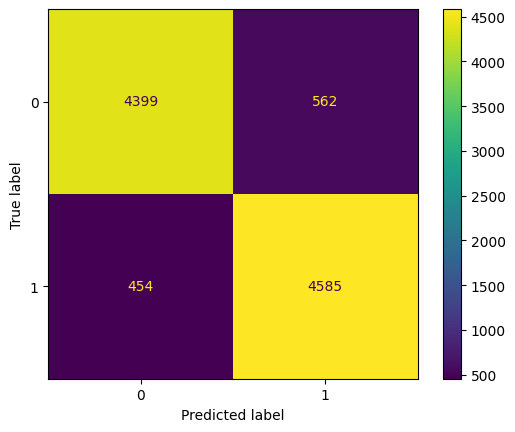

In [ ]:
matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=matrix).plot()

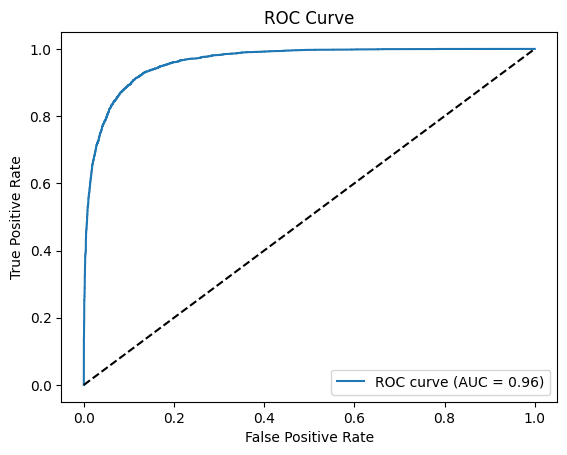

In [ ]:
y_prob = model_lr.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Text(0.5, 1.0, 'Distribución de opiniones')

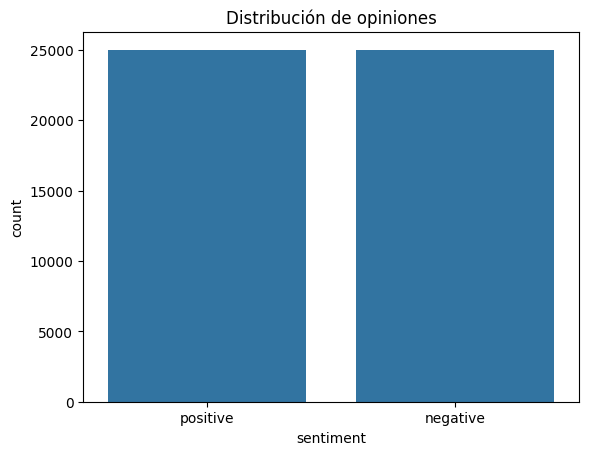

In [ ]:
sns.countplot(x='sentiment', data=df)
plt.title("Distribución de opiniones")

<Axes: title={'center': 'Palabras negativas más frecuentes'}, xlabel='Palabra'>

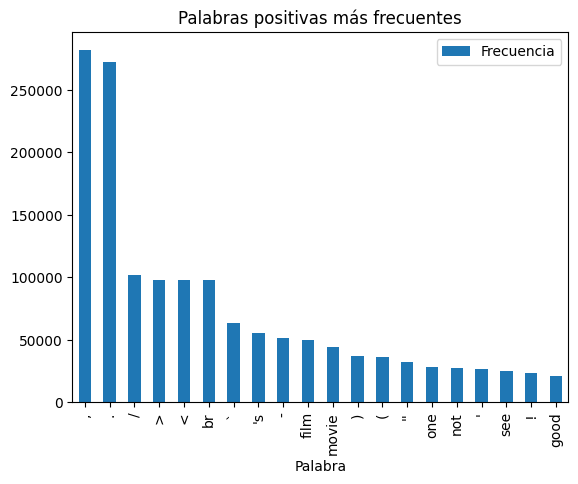

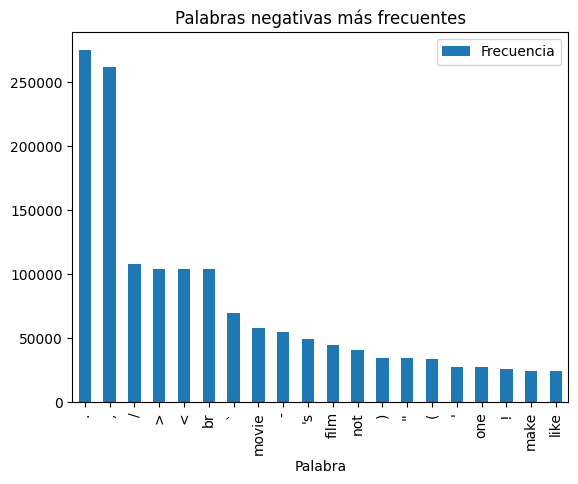

In [ ]:
positive_words = [word for tokens in df[df['sentiment']=='positive']['tokens'] for word in tokens]
negative_words = [word for tokens in df[df['sentiment']=='negative']['tokens'] for word in tokens]

pos_freq = Counter(positive_words).most_common(20)
neg_freq = Counter(negative_words).most_common(20)


pd.DataFrame(pos_freq, columns=['Palabra', 'Frecuencia']).plot.bar(x='Palabra', title='Palabras positivas más frecuentes')
pd.DataFrame(neg_freq, columns=['Palabra', 'Frecuencia']).plot.bar(x='Palabra', title='Palabras negativas más frecuentes')